<a href="https://colab.research.google.com/github/jinsunghub/HPC-System-Optimization/blob/main/Softmax_Regression_Dynamic_Scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OpenMP 기본 구조 및 변수 공유
* Hello world 병렬 출력
* private 변수
* firstprivate, lastprivate

In [ ]:
%%writefile basic_openmp.cpp

#include <iostream>
#include <omp.h>

int main() {
    int x = 0;

    // Make the following code parallel
    #pragma omp parallel
    {
        int num_threads = omp_get_num_threads();
        int tid = omp_get_thread_num();
        x += 1;
        printf("Thread %d of %d sees x = %d\n", tid, num_threads, x);
    }

    printf("After shared: x = %d\n\n", x);

    // Make the following code parallel using firstprivate
    #pragma omp parallel firstprivate(x)
    {
        int tid = omp_get_thread_num();
        x += tid;
        printf("Thread %d local x = %d\n", tid, x);
    }

    printf("After firstprivate: x = %d\n\n", x);

    // // Make the following code parallel using lastprivate
    #pragma omp parallel for lastprivate(x)

    for (int i = 0; i < 8; i++) {
        x = i;
    }

    printf("After lastprivate: x = %d\n", x);

    return 0;
}

Writing basic_openmp.cpp


In [ ]:
!g++ -O2 -std=c++14 -fopenmp basic_openmp.cpp -o basic_openmp

In [ ]:
!./basic_openmp

Thread 17 of 24 sees x = 14
Thread 23 of 24 sees x = 13
Thread 6 of 24 sees x = 12
Thread 9 of 24 sees x = 15
Thread 15 of 24 sees x = 14
Thread 8 of 24 sees x = 1
Thread 21 of 24 sees x = 1
Thread 20 of 24 sees x = 6
Thread 1 of 24 sees x = 9
Thread 14 of 24 sees x = 2
Thread 18 of 24 sees x = 3
Thread 3 of 24 sees x = 5
Thread 4 of 24 sees x = 10
Thread 2 of 24 sees x = 4
Thread 10 of 24 sees x = 11
Thread 0 of 24 sees x = 16
Thread 19 of 24 sees x = 14
Thread 12 of 24 sees x = 8
Thread 5 of 24 sees x = 7
Thread 16 of 24 sees x = 15
Thread 22 of 24 sees x = 16
Thread 7 of 24 sees x = 14
Thread 11 of 24 sees x = 14
Thread 13 of 24 sees x = 14
After shared: x = 16

Thread 0 local x = 16
Thread 1 local x = 17
Thread 8 local x = 24
Thread 4 local x = 20
Thread 18 local x = 34
Thread 3 local x = 19
Thread 14 local x = 30
Thread 6 local x = 22
Thread 22 local x = 38
Thread 19 local x = 35
Thread 11 local x = 27
Thread 7 local x = 23
Thread 17 local x = 33
Thread 12 local x = 28
Thread 16 l

Schedule 모드 실험
* N*D 크기의 double 타입 벡터 A (A[N][D])
* 즉, A[i]는 D개의 double로 이루어진 벡터
* 모든 i, j 쌍에 대해 A[i]와 A[j]의 유사도를 계산
* 유사도는 두 벡터의 내적 연산으로 구함

In [ ]:
%%writefile schedule_openmp.cpp

#include <bits/stdc++.h>
#include <omp.h>
using namespace std;

double dot(const vector<double>& a, const vector<double>& b){
    double s = 0.0;
    for (size_t k = 0; k < a.size(); k++)
        s += a[k] * b[k];
    return s;
}

int main(int argc, char** argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 4096;   // # of vectors
    int D = (argc > 2) ? atoi(argv[2]) : 128;    // vector dimension

    // Initialization
    vector<vector<double>> A(N, vector<double>(D));
    // Make the following for loop to parallel
    #pragma omp parallel for
    for (int i = 0; i < N; i++) {
        for (int k = 0; k < D; k++) {
            A[i][k] = ((i * 131 + k * 7) % 97) / 97.0;
        }
    }

    vector<double> S((size_t)N * (size_t)N, 0.0); // output matrix
    auto IDX = [&](int i, int j) { return (size_t)i * N + j; };

    double t0 = omp_get_wtime(); // record beginning time

    // Make the following for loop to parallel using schedule(runtime)
    #pragma omp parallel for schedule(runtime)
    for (int i = 0; i < N; i++) {
        for (int j = 0; j <= i; j++) {        // (A)
            double s = dot(A[i], A[j]);
            S[IDX(i, j)] = s;
            S[IDX(j, i)] = s;
        }
    }

    double t1 = omp_get_wtime(); // record finishing time

    printf("# N=%d D=%d  OMP_NUM_THREADS=%s  OMP_SCHEDULE=%s  time=%.3fs\n",
           N, D,
           getenv("OMP_NUM_THREADS") ? getenv("OMP_NUM_THREADS") : "(unset)",
           getenv("OMP_SCHEDULE")    ? getenv("OMP_SCHEDULE")    : "(unset)",
           t1 - t0);
    printf("S[0][0]=%f  S[N-1][N-1]=%f\n", S[IDX(0,0)], S[IDX(N-1,N-1)]);
}

Writing schedule_openmp.cpp


In [ ]:
!g++ -O2 -std=c++14 -fopenmp schedule_openmp.cpp -o schedule_openmp

In [ ]:
!OMP_NUM_THREADS=8 OMP_SCHEDULE=static,32 ./schedule_openmp 16384 128
!OMP_NUM_THREADS=8 OMP_SCHEDULE=dynamic,32 ./schedule_openmp 16384 128
!OMP_NUM_THREADS=8 OMP_SCHEDULE=guided,32 ./schedule_openmp 16384 128

# N=16384 D=128  OMP_NUM_THREADS=8  OMP_SCHEDULE=static,32  time=3.085s
S[0][0]=40.538527  S[N-1][N-1]=41.340312
# N=16384 D=128  OMP_NUM_THREADS=8  OMP_SCHEDULE=dynamic,32  time=3.282s
S[0][0]=40.538527  S[N-1][N-1]=41.340312
# N=16384 D=128  OMP_NUM_THREADS=8  OMP_SCHEDULE=guided,32  time=3.073s
S[0][0]=40.538527  S[N-1][N-1]=41.340312


1. 개요

 본 실험은 OpenMP의 schedule 모드(Static, Dynamic, guided)에 따른 성능 차이를 분석하는 것을 목표로 한다. 벡터의 수를 1024에서 16384까지 2의 배수로 증가시키며 실행 시간을 측정하였으며, 벡터 차원은 128, thread 수는 8, chunk size는 32로 고정하였다.

2. 실험 결과

1) N=1024

Static: (0.053 + 0.053 + 0.054) / 3 ≈ 0.053s

Dynamic: (0.052 + 0.053 + 0.054) / 3 ≈ 0.053s

Guided: (0.056 + 0.058 + 0.059) / 3 ≈ 0.058s

OMP_NUM_THREADS=1  

OMP_SCHEDULE=static,32  time=0.085s

OMP_SCHEDULE=dynamic,32  time=0.087s

OMP_SCHEDULE=guided,32  time=0.089s


2) N=2048

Static: (0.238 + 0.240 + 0.253) / 3 ≈ 0.244s

Dynamic: (0.231 + 0.232 + 0.246) / 3 ≈ 0.236s

Guided: (0.240 + 0.244 + 0.258) / 3 ≈ 0.247s

OMP_NUM_THREADS=1

OMP_SCHEDULE=static,32  time=0.362s

OMP_SCHEDULE=dynamic,32  time=0.351s

OMP_SCHEDULE=guided,32  time=0.349s


3) N=4096

Static: (1.004 + 1.004 + 1.005) / 3 ≈ 1.004s

Dynamic: (0.987 + 0.988 + 0.994) / 3 ≈ 0.990s

Guided: (1.068 + 1.073 + 1.080) / 3 ≈ 1.074s

OMP_NUM_THREADS=1

OMP_SCHEDULE=static,32  time=1.440s

OMP_SCHEDULE=dynamic,32  time=1.446s

OMP_SCHEDULE=guided,32  time=1.453s


4) N=8192

Static: (4.326 + 4.433 + 4.771) / 3 ≈ 4.510s

Dynamic: (4.147 + 4.153 + 4.212) / 3 ≈ 4.171s

Guided: (6.052 + 6.128 + 6.131) / 3 ≈ 6.104s

OMP_NUM_THREADS=1

OMP_SCHEDULE=static,32  time=6.069s

OMP_SCHEDULE=dynamic,32  time=6.068s

OMP_SCHEDULE=guided,32  time=6.390s


5) N=16384

Static: (20.496 + 21.127 + 21.365) / 3 ≈ 20.996s

Dynamic: (19.233 + 21.088 + 21.404) / 3 ≈ 20.575s

Guided: (23.372 + 24.776 + 25.297) / 3 ≈ 24.482s

OMP_NUM_THREADS=1

OMP_SCHEDULE=static,32  time=29.149s

OMP_SCHEDULE=dynamic,32  time=28.240s

OMP_SCHEDULE=guided,32  time=27.861s


3. 결과 분석 및 고찰

모든 N 크기에서 dynamic 방식 스케줄링이 가장 빠른 성능을 보였다. 반면 guided는 N이 커질수록 static보다도 느린 성능을 보여주며 가장 저조한 효율을 나타냈다.
이 실험은 변수 i에 대한 for문 내부에 변수 j에 대한 for문이 중첩된 구조인데 반복 횟수가 선형적으로 감소한다.

Static Schedule은 반복 구간을 미리 32개씩 나누어 thread에 할당한다. 앞쪽 번호의 chunk들을 할당받은 thread는 뒤쪽 번호의 chunk를 받은 thread보다 훨씬 많은 연산을 수행해야 한다. 이로 인해 작업이 일찍 끝난 thread가 늦게 끝나는 tread를 기다려서 전체 성능이 저한된다.

Dynamic Schedule은 thread가 현재 할당받은 32개 반복 작업을 마치면 즉시 다음 작업 큐에서 새로운 chunk를 가져온다. 초반의 많은 양의 일 때문에 늦어지는 thread가 있더라도 다른 thread들이 빠르게 나누어 처리하므로 전체적인 load balance가 가장 효율적으로 이루어진다.

Guieded Schedule은 초기에 매우 큰 청크를 할당하고 점차 줄여나가는 방식이다. 특정 thread가 초반의 거대하고 무거운 chunk를 혼자 처리하는 동안 병목 현상이 발생하여 오히려 dynamic 방식보다 효율이 떨어지는 결과가 나온 것으로 보인다.

N이 작을 때는 병렬 처리 시간과 Sequential 시간의 차이가 크지 않으나 N이 커질수록 차이는 더 커진다. 이는 thread 생성 및 Scheduling 오버헤드 때문이다.

4. 결론

내부 loop의 반복 횟수가 변하여 반복문 간의 작업량 편차가 심한 load imbalance 경우에는 작업 상황에 따라 유동적으로 chunk를 할당하는 Dynamic Scheduling 방식이 가장 적합하다.

5. for (int j = 0; j <= i; j++) 변경

이 코드로 바꾸면 loop가 진행됨에 따라 내부 반복 횟수가 늘어나는 정삼각형 형태이다. 초반부의 작업량이 매우 적고 후반부로 갈수록 작업량이 늘어난다.

Dynamic Schedule로 처리하면 작업량이 급격히 변하는 구간에서도 일찍 끝난 thread가 대기 없이 다음 작업을 가져가므로 thread 간의 idle time을 최소화하여 가장 빠른 성능을 보였다.

반면 Guided Schedule 방식은 이번 코드는 초반에는 작업량이 적은데 너무 큰 chunk를 할당 받았고 후반에는 작업량이 큰데 작은 chunk를 할당받아서 static보다도 느린 결과를 보였다.

Loop의 작업량이 i에 따라 변하는 상황에서는 작업량이 줄어주는 구조이든 늘어나는 구조이든 관계없이 Dynamic Schedule이 가장 우수한 성능을 보임을 확인할 수 있었다.

Softmax Regression Inference
* 4,096장의 이미지, 이미지 당 784픽셀로 이루어진 dataset x_batch에 대해서, 각 이미지에 대해 softmax_regression을 통해 dimension이 10인 output vector를 예측하는 작업
* num_images = 4096
* d = 784 (# of pixels)
* c = 10 (output classes)

수행 내용
1) 아래 코드의 softmax_infer 내부의 parallel 부분들에 대한 thread 생성 및 스케줄링 비용이 최소화되도록 수정
- #pragma omp prallel를 한 번만 작성하고 #pragma omp for를 내부에서 나눠서 작성하는 형태로 변경
- 병합할 수 있는 for문들은 병합하여 #pragma omp for 횟수를 줄이기
2) 실습 3에 대한 실험 보고서 작성(아래 설명 참조)

In [ ]:
%%writefile softmax_regression_inference.cpp

#include <bits/stdc++.h>
#include <omp.h>
using namespace std;

void softmax_infer(const double* x, const double* W, const double* b, int d, int c, double* y, bool inner_parallel){
    // W[c][d], w[d]

    vector<double> z(c);
    double mu = -numeric_limits<double>::infinity();
    double norm = 0.0;

    #pragma omp parallel if(inner_parallel)
    {

    // 1) z = Wx + b
    #pragma omp for
    for(int i=0;i<c;i++){
        double acc=0.0;
        const double* Wi = W + (size_t)i*d;
        for(int j=0;j<d;j++) acc += Wi[j]*x[j];
        z[i] = acc + b[i];
    }

    // 2) mu = max(z)
    #pragma omp for reduction(max:mu)
    for(int i=0;i<c;i++){
        mu = max(mu, z[i]);
    }

    // 4) norm = sum(y)
    #pragma omp for reduction(+:norm)
    for(int i=0;i<c;i++) {
        y[i] = exp(z[i]-mu);
        norm += y[i];
    }

    // 5) normalize
    #pragma omp for
    for(int i=0;i<c;i++) y[i] /= norm;
    }

}

int main(int argc,char**argv){
    int d = 784;
    int c = 10;
    int num_images = 4096;

    bool outer_parallel = (argc>1) ? atoi(argv[1]) : 0;
    bool inner_parallel = (argc>2) ? atoi(argv[2]) : 0;

    vector<double> W((size_t)c*(size_t)d), b(c); // Weight & bias
    vector<double> x_batch(num_images*d), y_batch(num_images*c); // input and output

    // 임의 데이터 초기화
    for(int i=0;i<num_images*d;i++) x_batch[i] = (i%17)/17.0;
    for(int i=0;i<c;i++) b[i] = 0.01*i;
    for(int i=0;i<c*d;i++) W[i] = ((i%23)-11)/23.0;

    double t0 = omp_get_wtime();
    #pragma omp parallel for if(outer_parallel) schedule(static, 64)
    for (int i = 0; i < num_images; i++)
      softmax_infer(&x_batch[i*d], W.data(), b.data(), d, c, &y_batch[i*c], inner_parallel);
    double t1 = omp_get_wtime();

    printf("# time=%.6fs\n", t1-t0);
}

Writing softmax_regression_inference.cpp


In [ ]:
!g++ -O2 -std=c++14 -fopenmp softmax_regression_inference.cpp -o softmax_regression_inference

In [ ]:
!./softmax_regression_inference 0 0
!./softmax_regression_inference 1 0
!./softmax_regression_inference 0 1
!./softmax_regression_inference 1 1

# time=0.033023s
# time=0.003802s
# time=24.859976s
# time=0.003924s




[실습 3 실험 보고서]

1. 개요

본 실험은 Softmax Regression 코드에 대해 OpenMP 병렬화를 적용하고 병렬화 전략에 따른 성능 차이를 분석하는 것을 목표로 한다. 실험 대상은 4096장의 이미지이며 출력 클래스는 10개이다.

2. 실험 결과

Sequential: (0.058122 + 0.058363 + 0.058976) / 3 ≈ 0.0585s

Outer Parallel: (0.032230 + 0.032478 + 0.033601) / 3 ≈ 0.0328s

Inner Parallel: (0.156080 + 0.162419 + 0.179945) / 3 ≈ 0.1661s

Outer & Inner: (0.030848 + 0.031684 + 0.032888) / 3 ≈ 0.0318s

Outer Loop Parallel은 Sequential 대비 약 1.78배의 속도 향상을 보였다. Outer Loop는 처리해야할 이미지의 개수만큼 반복되는데 작업 단위가 크고 반복 횟수가 많다. thread들에게 Coarse grained로 분배하게 되어 thread 생성 대비 병렬 처리 이득이 훨씬 크다.

Inner Loop Parallel은 Sequential보다 약 3배 느려지는 결과를 보였다. 이는 작업의 단위가 작은 Fine grain으로 처리하고 실제 연산 시간보다 thread를 생성하고 동기화하는 오버헤드가 훨씬 더 크기 때문이다.

Outer & Inner Parallel은 가장 빠르나 Outer Parallel과 큰 차이 없다. 사실상 Outer Loop 병렬화가 지배적이기 때문이다.

3. 결론

병렬 프로그래밍 작업 시 작업 단위를 정하는 것은 매우 중요하다. 너무 작은 작업 단위에 병렬화를 적용하면 오버헤드로 인해 오히려 성능이 저하될 수 있다. 본 실험에서는 Outer Loop를 병렬화하는 것이 가장 효율적임을 확인했다.

Monte Carlo 방식으로 π 근사하기
* 아래 그림에는 단위 정사각형 안에 반지름의 길이가 1인 원의 1/4조각이 겹쳐져 나타남
* 정사각형의 넓이는 1
* 원의 넓이는 π/4
* 해당 그림에 임의로 점 N개를 찍는다고 가정하면, 어떤 점은 원 안에 찍히고, 어떤 점은 원 밖에 찍힘.
* 이 때, 원 안에 들어갈 확률은 면적 비율과 동일함.
* 즉, N개 중에 π/4 * N개만 원 안에 들어감.
* inside = π/4 * N
* π = 4 * inside/N
* 점이 찍히는 위치는 원점으로부터의 거리(root(x^2 + y^2))가 1보다 작은지를 가지고 원 안/밖을 판단할 수 있음.

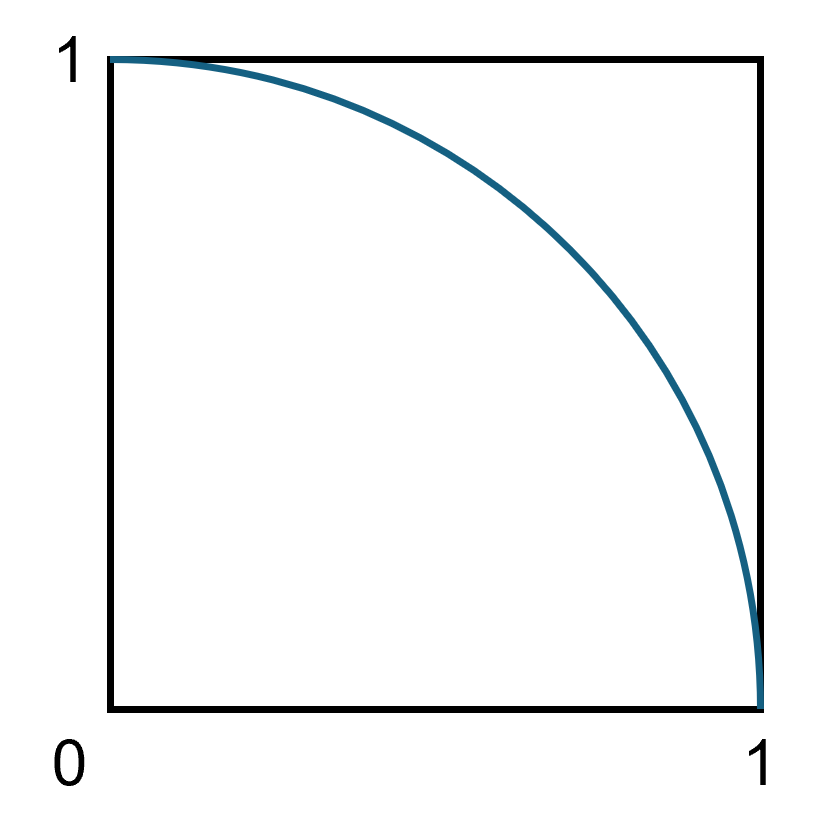

In [ ]:
%%writefile pi_calculator.cpp

#include <bits/stdc++.h>
#include <omp.h>
using namespace std;

int main(int argc, char** argv) {
    long N = (argc > 1) ? atol(argv[1]) : 5e7;

    long inside = 0;

    double t0 = omp_get_wtime();   // 시작 시간

    #pragma omp parallel reduction(+:inside)
    {
       // thread 별 서로 다른 random 숫자 생성을 위해서 아래 두 line은 parallel 영역 안에 들어가야 함.
    std::mt19937_64 rng(1234ULL + 0x9e3779b97f4a7c15ULL * omp_get_thread_num());
    std::uniform_real_distribution<double> U(0.0, 1.0);

    #pragma omp for
    for (long i = 0; i < N; i++) {
        double x = U(rng);
        double y = U(rng);
        if (x*x + y*y <= 1.0)
            inside++;
    }
  }

    double t1 = omp_get_wtime();   // 종료 시간

    double pi = 4.0 * (double)inside / (double)N;
    double elapsed = t1 - t0;

    printf("N=%ld  threads=%d  pi=%.8f  time=%.6fs\n",
           N,  omp_get_max_threads(), pi, elapsed);

    return 0;
}

Writing pi_calculator.cpp


In [ ]:
!g++ -fopenmp pi_calculator.cpp -o pi_calculator

In [ ]:
!OMP_NUM_THREADS=1 ./pi_calculator
!OMP_NUM_THREADS=2 ./pi_calculator
!OMP_NUM_THREADS=4 ./pi_calculator

N=50000000  threads=1  pi=3.14177136  time=5.430741s
N=50000000  threads=2  pi=3.14123632  time=2.708157s
N=50000000  threads=4  pi=3.14115640  time=1.400364s




[실습 4 실험 보고서]

1. 개요

본 실험은 Monte Carlo 시뮬레이션을 통해 월주율을 근사하는 프로그램을 OpenMP를 사용하여 병렬화하고 thread 수 변화에 따른 성능 추이를 분석하는 것을 목표로 한다.

2. 코드 구현 설명
```
#pragma omp parallel reduction(+:inside)
```
각 thread가 계산한 원 내부의 점 개수를 race condition 없이 합산하기 위해 사용했다.


```
{
    std::mt19937_64 rng(1234ULL + 0x9e... * omp_get_thread_num());
    ...
}
```
parallel 영역 내부에서 난수 생성기를 선언하고 Seed 값에 omp_get_thread_num()을 더하여 초기화하였다.



```
#pragma omp for
for (long i = 0; i < N; i++) { ... }
```
전체 반복횟수 N을 thread 개수만큼 나누어 할당하기 위해 사용했다.

3. 실험 결과

N=50000000  threads=1  pi=3.14177136  time=7.158673s


N=50000000  threads=2  pi=3.14123632  time=4.538216s


N=50000000  threads=4  pi=3.14115640  time=5.806888s

4. 결과 분석 및 고찰

모든 케이스에서 계산된 파이 값이 실제 값이랑 매우 근접한 값을 보여 병렬화 코드가 race condition 없이 정상 동작함을 확인했다.

thread=2일때는 예상했듯이 속도 향상을 이루었지만 threads=4일때 오히려 성능이 저하되었다. 이는 보통 CPU는 물리 코어가 2개인데 thread를 강제로 4개로 실행하게 하여 오버헤드가 증가한 것으로 보인다.

5. 결과

Monte Carlo 시뮬레이션은 병렬화 효율이 높은 작업이지만 실제 성능 향상은 물리 코어의 개수에 종속된다. 본 실험에서는 2개의 thread에서 최적의 성능을 확인했다.

